<a href="https://colab.research.google.com/github/Ivelina0/Dissertation_code/blob/main/Chapter_3_Part_2_COVID_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Covid-19 Data - Cases by Specimen date


https://coronavirus.data.gov.uk/details/cases

Using the Cases by specimen date.

Importing data to google colab https://towardsdatascience.com/google-colab-import-and-export-datasets-eccf801e2971



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pandas as pd
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [3]:
# import data with Pandas into a DataFrame: COV_all
COV_all = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/data_2021-May-11 Cases by specimen date.csv')

# make the dates column into datetime data type for ease of use
COV_all['Date']= pd.to_datetime(COV_all['date'])

# Filter out all the dats for covid cases after the first date back to school 
Cov_sept = COV_all[COV_all['Date'] > pd.to_datetime('2020-09-06')]

# checking the values in column date are between 08-09-2020 and the last date in 2021
Cov_sept['Date'].sort_values(ascending=True)

244   2020-09-07
243   2020-09-08
242   2020-09-09
241   2020-09-10
240   2020-09-11
         ...    
4     2021-05-05
3     2021-05-06
2     2021-05-07
1     2021-05-08
0     2021-05-09
Name: Date, Length: 245, dtype: datetime64[ns]

# Getting the AVR COVID cases per week by the Specimen date

The new COVID cases per day by Specimen Date.

In [4]:
cases_day = Cov_sept['newCasesBySpecimenDate'].values
# We can have 35 means: n=35 x 7 array
cases_day.size

245

In [5]:
np.where(cases_day == 0)  # no 0 cases!

(array([], dtype=int64),)

In [6]:
cs_day_seven = cases_day.reshape(-1,7)

cs_day_seven.shape # have 35 means

(35, 7)

In [7]:
# take the average number of cases per week 
avr_week_cases = np.average(cs_day_seven, axis=1)
avr_week_cases

array([ 2164.57142857,  2034.28571429,  2288.42857143,  2389.28571429,
        2781.57142857,  3160.71428571,  5059.14285714,  5392.28571429,
        5540.        ,  5610.42857143,  7566.28571429, 10856.28571429,
       12195.42857143, 16943.71428571, 22926.71428571, 31355.14285714,
       41998.71428571, 53284.57142857, 56873.57142857, 38475.71428571,
       32976.71428571, 21682.71428571, 15509.28571429, 14636.71428571,
       18458.85714286, 24053.57142857, 23764.28571429, 21791.85714286,
       21867.85714286, 17595.71428571, 15785.        , 11850.42857143,
        6805.71428571,  4436.71428571,  3169.28571429])

# The parameter update functions

In [8]:
np.set_printoptions(formatter={'float_kind':'{:f}'.format})

########################################
## Lambdas
########################################

def find_lambda(data, mu_init, ga_init, al_init):

  n = len(data)

  lambda_list = np.ones(n+1)

  lambda_list[0] = mu_init

  for i in range(1,n+1):
      
      lambda_k_plus_1 = (lambda_list[i-1] - mu_init)*ga_init + mu_init + al_init*data[i-1]

      lambda_list[i] = lambda_k_plus_1

  lambda_list = lambda_list.reshape(n+1,1)
    
  return lambda_list

########################################
## Mu
########################################

def find_mu(data, mu_, lambda_list):

  n = len(data)

  mu_update = (1/n)*np.sum(np.divide(mu_*data , lambda_list[:-1, :] ))
    
  return mu_update

########################################
## Alpha
########################################

def find_alpha(data, alpha_, gamma_, lambda_list):

  n = len(data)

  # starts from k=2 to k = N, so we need N-1 balues 
  A = np.zeros((n-1, 1))

  # create constants - need to start from second value k=2 (index is 1 )
  C = (data/lambda_list[:-1, :])

  # add initial value
  A[0] =  data[0]*C[1]

  for j in range(1, n-1):

    A[j] = (gamma_*(A[j-1]/C[j]) +  data[j])*C[j+1]

  D = np.sum(A*alpha_)

  # A = sum of the first N-2 data points * (1+gamma)/alpha
  A = (1 + gamma_)*np.sum(data[:-2, :])/alpha_

  B = data[-1,:]

  alpha_update = ( -B + np.sqrt(B**2 + 4*A*D) )/ (2*A)
    
  return alpha_update

########################################
## Gamma
########################################

def find_gamma(data, alpha_, gamma_, lambda_list):

  n = len(data)

  # starts from k=3 to k = N, so we need N-2 values 
  K = np.zeros((n-2, 1))

  # create constants - need to start from second value k=3 (index is 2 )
  G = (data/lambda_list[:-1, :])

  # add initial two values
  K[0] =  gamma_*data[0]*G[2]
  K[1] = ((K[0]/G[2])*2*gamma_ + gamma_*data[1])*G[3]

  # for loop the rest N-2-2 values
  for l in range(2, n-2):

    # K[2]  =((K[1]/G[3])*2*ga_init - (K[0]/G[2])*(ga_init**2) + ga_init*data1000[2])*G[4]

    K[l]  =((K[l-1]/G[l+1])*2*gamma_ - (K[l-2]/G[l])*(gamma_**2) + gamma_*data[l])*G[l+2]

  F = - np.sum(K*alpha_)

  # this one is both a and c in the quadratic eqn
  P = (alpha_/ (gamma_ + 1))* np.sum(data[:-2,:])

  gamma_update = (-P + np.sqrt(P**2 - 4*F*P))/(2*P) 
    
  return gamma_update

########################################
####### FIND ALL PARAMETERS function 
########################################

def find_param(itr, mu0, ga0, al0, data):

  n = len(data)

  iter = itr

  neg_log_likelihood = np.zeros((iter,1))

  mu_arr = np.zeros(iter)
  mu_arr[0] = mu0

  alpha_arr = np.zeros(iter)
  alpha_arr[0] = al0

  gamma_arr = np.zeros(iter)
  gamma_arr[0] = ga0

  for i in range(1,iter):
    
    # initialising the values & updating them for the loop
    mu_val = mu_arr[i-1]
    al_val = alpha_arr[i-1]
    ga_val = gamma_arr[i-1]

    # finding the lambda estimates with the parameter values 
    lambda_list = find_lambda(data, mu_val, ga_val, al_val)

    mu_arr[i] = find_mu(data, mu_val, lambda_list)

    alpha_arr[i] = find_alpha(data, al_val, ga_val, lambda_list)

    gamma_arr[i] = find_gamma(data, al_val, ga_val, lambda_list)
    
    mult_vals = np.multiply(data, np.log(lambda_list[:-1, :]))
    
    neg_log_likelihood[i] = -np.sum(mult_vals) + np.sum(lambda_list)

  return mu_arr, alpha_arr, gamma_arr, neg_log_likelihood

# Model using average cases overall as initial mu

In [9]:
# reshape into an array I can plug into the parameter updating function
avr_week_cases = avr_week_cases.reshape(-1,1)

# Set the initial mu to be the overall average cases for the 35 week period
mu_init = np.average(avr_week_cases)
mu_init

16665.18775510204

In [56]:
# Testing it for 50 iterations

mu_updates, alpha_updates, gamma_updates, neg_log_likelihood_updates = find_param(itr= 50, mu0 = mu_init, ga0 = 0.01, al0 = 0.25, data = avr_week_cases)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: overflow encountered in multiply
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:92: RuntimeWarning: overflow encountered in multiply
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in subtract


In [11]:
mu_updates, alpha_updates, gamma_updates, neg_log_likelihood_updates[1:]

(array([16665.187755, 12038.364782, 10788.793820, 9865.439122, 8985.600754]),
 array([0.250000, 0.263193, 0.304312, 0.351469, 0.400629]),
 array([0.010000, 0.010638, 0.013655, 0.017595, 0.022262]),
 array([[-5120481.896714],
        [-5158661.884790],
        [-5172054.382421],
        [-5184511.572052]]))

In [12]:
# Testing it for 50 iterations

mu_updates, alpha_updates, gamma_updates, neg_log_likelihood_updates = find_param(itr= 50, mu0 = mu_init, ga0 = 0.01, al0 = 0.25, data = avr_week_cases)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: overflow encountered in multiply
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:92: RuntimeWarning: overflow encountered in multiply
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in subtract


In [13]:
mu_updates, alpha_updates, gamma_updates, neg_log_likelihood_updates[1:]

(array([16665.187755, 12038.364782, 10788.793820, 9865.439122, 8985.600754,
        8128.733530, 7308.021600, 6538.316484, 5830.423491, 5190.143369,
        4618.661498, 4113.458575, 3669.349993, 3279.402259, 2935.569544,
        2628.945837, 2349.506253, 2085.052882, 1818.611947, 1522.201526,
        1141.114284, 562.324902, 97.538469, 67.800917, 69.602549,
        76.023083, 86.355078, 98.724680, 108.906204, 114.937973,
        117.972040, 119.437831, 120.143016, 120.482327, 120.645624,
        120.724219, 120.762049, 120.780258, 120.789023, 120.793242,
        120.795273, 120.796250, 120.796720, 120.796947, 120.797056,
        120.797108, 120.797134, 120.797146, 120.797152, 120.797155]),
 array([0.250000, 0.263193, 0.304312, 0.351469, 0.400629, 0.449920,
        0.497879, 0.543271, 0.585117, 0.622737, 0.655730, 0.683931,
        0.707333, 0.726001, 0.739980, 0.749194, 0.753313, 0.751554,
        0.742328, 0.722489, 0.685552, 0.616180, 0.458657, 0.219035,
        0.104365, 0.049999, 

 It blows up! after 21 iterations.

In [14]:
# Testing it for 21 iterations

mu_updates, alpha_updates, gamma_updates, neg_log_likelihood_updates = find_param(itr= 21, mu0 = mu_init, ga0 = 0.01, al0 = 0.25, data = avr_week_cases)

In [15]:
mu_updates, alpha_updates, gamma_updates, neg_log_likelihood_updates[1:]

(array([16665.187755, 12038.364782, 10788.793820, 9865.439122, 8985.600754,
        8128.733530, 7308.021600, 6538.316484, 5830.423491, 5190.143369,
        4618.661498, 4113.458575, 3669.349993, 3279.402259, 2935.569544,
        2628.945837, 2349.506253, 2085.052882, 1818.611947, 1522.201526,
        1141.114284]),
 array([0.250000, 0.263193, 0.304312, 0.351469, 0.400629, 0.449920,
        0.497879, 0.543271, 0.585117, 0.622737, 0.655730, 0.683931,
        0.707333, 0.726001, 0.739980, 0.749194, 0.753313, 0.751554,
        0.742328, 0.722489, 0.685552]),
 array([0.010000, 0.010638, 0.013655, 0.017595, 0.022262, 0.027599,
        0.033576, 0.040186, 0.047463, 0.055505, 0.064501, 0.074765,
        0.086790, 0.101338, 0.119614, 0.143594, 0.176724, 0.225502,
        0.303632, 0.445126, 0.761617]),
 array([[-5120481.896714],
        [-5158661.884790],
        [-5172054.382421],
        [-5184511.572052],
        [-5196316.222071],
        [-5207181.744869],
        [-5216870.477371],
     

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

In [17]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


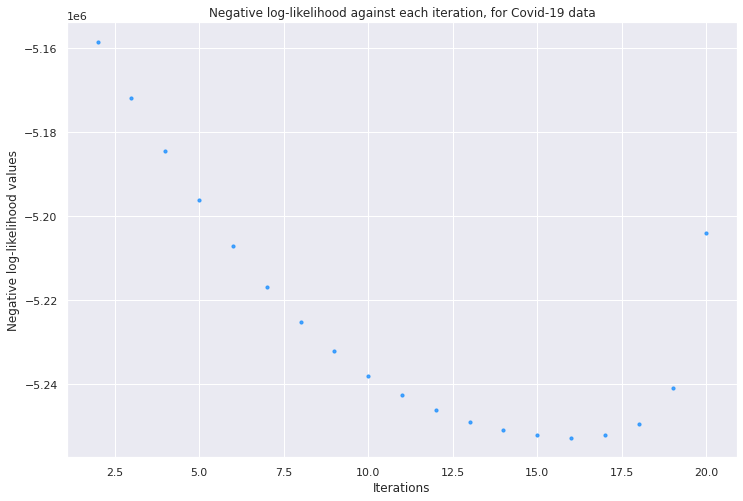

In [18]:
# Exclude the negative log-likelihood for the initial parameters.

# Setting the x-axis to be the number of iterations
x = np.arange(neg_log_likelihood_updates.shape[0])

fig = plt.figure( figsize = (12,8))

plt.scatter(x[2:], neg_log_likelihood_updates[2:], c='dodgerblue', alpha=0.8, s=10)
plt.xlabel("Iterations" ) # \n for the true parameters $ \mu = 8$, $\gamma = 0.1 $ and $ \alpha = 0.25 $ ')
plt.ylabel("Negative log-likelihood values")
plt.title("Negative log-likelihood against each iteration, for Covid-19 data")

fig.savefig("/content/gdrive/My Drive/Colab Notebooks/COVID_negative_log_likelihood.png", dpi=200,transparent=True);

In [19]:
# where is the smallest negative log-likelihood

np.where(neg_log_likelihood_updates == min(neg_log_likelihood_updates))  

(array([16]), array([0]))

In [20]:
# what are the parameters for the smallest negative log-likelihood

mu_updates[15], alpha_updates[15], gamma_updates[15], neg_log_likelihood_updates[15]

(2628.945837164436,
 0.7491943733464697,
 0.1435943148250654,
 array([-5252305.729654]))

# Generating data with these parameters

In [21]:
# Create synthetic data function

def generate_data(n, rnd_seed, mu, gamma, alpha ):

    # fixing the randomness
    np.random.seed(rnd_seed)
    
    Lambda_ = np.zeros(n+1)
    
    # First lambda(0) = mu
    Lambda_[0] = mu ## adding the first lambda_k = mu

    # Delta_n and lambda_n empty lists
    Delta_n = np.zeros(n) ## adding a dummy data point    
    
    #Generating the lambda function and synthetic data
    for i in range(0,n):

        # draw from poisson distribution
        Delta_n[i] = np.random.poisson(Lambda_[i], size=1)

        # update lambda k+1
        Lambda_[i+1] = gamma*(Lambda_[i] - mu) + mu + alpha*Delta_n[i]
    
    return Lambda_, Delta_n

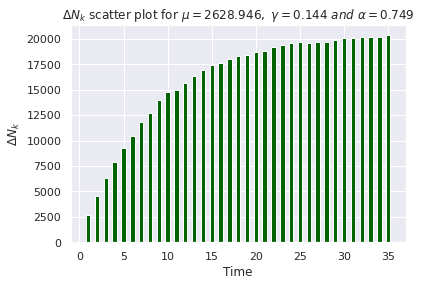

In [22]:
# Setting the no. of data points
n0 = 35
rnd_seed = 98 # random seed set

# Setting the parameters 
mu0 = mu_updates[15]
alpha0 = alpha_updates[15]
gamma0 = gamma_updates[15]

Lambda0_, Delta0_n = generate_data(n0, rnd_seed, mu0, gamma0, alpha0)

x1 = range(1,n0+1)

plt.bar(x1, Delta0_n[0:] ,  width=0.5,  color = 'darkgreen')

plt.title(r'$\Delta N_k $ scatter plot for $ \mu = {} , \ \gamma = {} \ and \ \alpha = {}  $'.format(np.round(mu0,3), np.round(gamma0,3), np.round( alpha0, 3)))
plt.xlabel('Time')
plt.ylabel('$ \Delta N_k$');

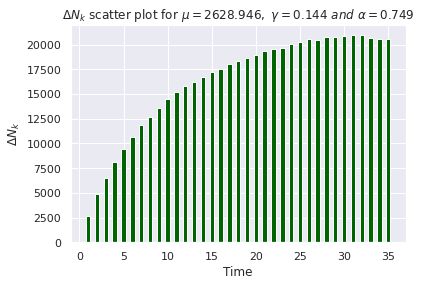

In [23]:
# Setting the no. of data points
n0 = 35
rnd_seed = 4 # random seed set to 4 

# Setting the parameters 
mu0 = mu_updates[15]
alpha0 = alpha_updates[15]
gamma0 = gamma_updates[15]

Lambda0_, Delta0_n = generate_data(n0, rnd_seed, mu0, gamma0, alpha0)

x1 = range(1,n0+1)

plt.bar(x1, Delta0_n[0:] ,  width=0.5,  color = 'darkgreen')

plt.title(r'$\Delta N_k $ scatter plot for $ \mu = {} , \ \gamma = {} \ and \ \alpha = {}  $'.format(np.round(mu0,3), np.round(gamma0,3), np.round( alpha0, 3)))
plt.xlabel('Time')
plt.ylabel('$ \Delta N_k$');

x1 = range(1,n0+1)

plt.bar(x1, Delta0_n[0:] ,  width=0.5,  color = 'darkgreen')

plt.title(r'$\Delta N_k $ scatter plot for $ \mu = {} , \ \gamma = {} \ and \ \alpha = {}  $'.format(np.round(mu0,3), np.round(gamma0,3), np.round( alpha0, 3)))
plt.xlabel('Time')
plt.ylabel('$ \Delta N_k$');

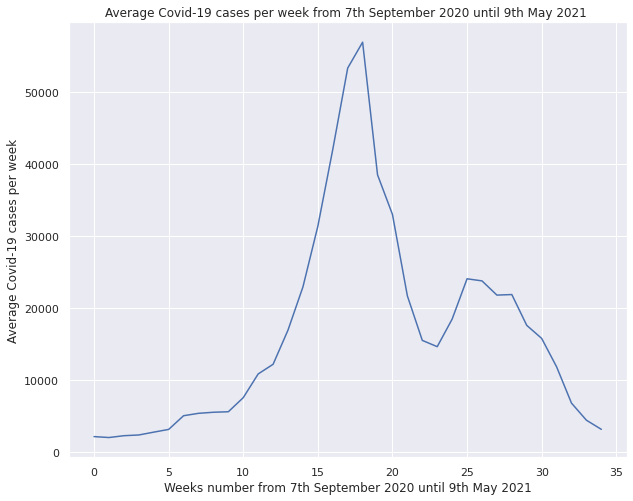

In [24]:
x2 = range(0,avr_week_cases.shape[0])

fig = plt.figure(figsize = (10,8))

plt.plot(x2, avr_week_cases) 
plt.xlabel('Weeks number from 7th September 2020 until 9th May 2021')
plt.ylabel('Average Covid-19 cases per week')

plt.title("Average Covid-19 cases per week from 7th September 2020 until 9th May 2021 ")

fig.savefig("/content/gdrive/My Drive/Colab Notebooks/COVID_avr_cases_week.png", dpi=200,transparent=True);

# More trials with different initial parameters for mu and gamma

# al0 = 0.2

In [66]:
# Testing it for 50 iterations

mu_updates, alpha_updates, gamma_updates, neg_log_likelihood_updates = find_param(itr= 50, mu0 = mu_init, ga0 = 0.01, al0 = 0.2, data = avr_week_cases)
mu_updates, alpha_updates, gamma_updates, neg_log_likelihood_updates

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: overflow encountered in multiply
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:92: RuntimeWarning: overflow encountered in multiply
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in subtract


(array([16665.187755, 12702.202913, 11606.883672, 10731.900877,
        9858.398786, 8979.086998, 8112.140572, 7277.033074, 6489.595089,
        5760.374017, 5094.172798, 4490.223677, 3942.520176, 3439.681186,
        2963.339762, 2482.867954, 1940.408509, 1209.524451, 224.744928,
        73.688742, 68.583543, 73.349409, 82.317853, 94.392895, 105.783264,
        113.242326, 117.141574, 119.037980, 119.950655, 120.389761,
        120.601074, 120.702777, 120.751728, 120.775290, 120.786632,
        120.792091, 120.794718, 120.795983, 120.796592, 120.796885,
        120.797026, 120.797094, 120.797127, 120.797143, 120.797150,
        120.797154, 120.797156, nan, nan, nan]),
 array([0.200000, 0.217885, 0.256806, 0.301390, 0.348846, 0.397597,
        0.446145, 0.493025, 0.536911, 0.576688, 0.611485, 0.640626,
        0.663519, 0.679470, 0.687364, 0.685106, 0.668428, 0.627685,
        0.531470, 0.284924, 0.135417, 0.064779, 0.031092, 0.014945,
        0.007189, 0.003459, 0.001665, 0.000801, 0.

## al0 = 0.3

In [67]:
# Testing it for 50 iterations - larger gamma 

mu_updates, alpha_updates, gamma_updates, neg_log_likelihood_updates = find_param(itr= 100, mu0 = mu_init, ga0 = 0.01, al0 = 0.3, data = avr_week_cases)
mu_updates, alpha_updates, gamma_updates, neg_log_likelihood_updates

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: overflow encountered in multiply
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:92: RuntimeWarning: overflow encountered in multiply
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in subtract


(array([16665.187755, 11452.521390, 10075.800394, 9124.974525, 8256.388441,
        7433.653293, 6663.127943, 5954.424753, 5313.628036, 4742.552253,
        4239.426003, 3799.926818, 3418.190598, 3087.636272, 2801.555375,
        2553.476848, 2337.343603, 2147.539620, 1978.792537, 1825.949880,
        1683.580859, 1545.265639, 1402.230009, 1240.463270, 1034.022570,
        728.667182, 245.975893, 75.354114, 67.489255, 71.232533, 78.951763,
        90.316026, 102.435213, 111.285508, 116.164442, 118.566546,
        119.723866, 120.280636, 120.548556, 120.677499, 120.739562,
        120.769434, 120.783813, 120.790734, 120.794065, 120.795669,
        120.796441, 120.796812, 120.796991, 120.797077, 120.797119,
        120.797139, 120.797148, 120.797153, 120.797155, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 

## al0 = 0.4

In [68]:
# Testing it for 50 iterations - larger gamma 

mu_updates, alpha_updates, gamma_updates, neg_log_likelihood_updates = find_param(itr= 50, mu0 = mu_init, ga0 = 0.01, al0 = 0.4, data = avr_week_cases)
mu_updates, alpha_updates, gamma_updates, neg_log_likelihood_updates

(array([16665.187755, 10461.604559, 8891.499082, 7922.117897, 7100.506862,
        6357.126875, 5683.759155, 5080.665059, 4546.961417, 4079.411353,
        3672.964875, 3321.555451, 3018.778071, 2758.368922, 2534.499551,
        2341.926849, 2176.043137, 2032.863718, 1908.979561, 1801.493873,
        1707.954245, 1626.287057, 1554.737475, 1491.816330, 1436.253894,
        1386.959943, 1342.989074, 1303.510057, 1267.777798, 1235.106219,
        1204.839867, 1176.321154, 1148.848430, 1121.616845, 1093.627692,
        1063.539173, 1029.404627, 988.183738, 934.767319, 859.883380,
        745.234264, 551.683984, 215.939406, 74.080821, 67.199292,
        70.861790, 78.358622, 89.551351, 101.756998, 110.868538]),
 array([0.400000, 0.385399, 0.423842, 0.471052, 0.518883, 0.564735,
        0.607412, 0.646288, 0.681095, 0.711819, 0.738629, 0.761814,
        0.781723, 0.798730, 0.813198, 0.825466, 0.835837, 0.844577,
        0.851914, 0.858040, 0.863115, 0.867269, 0.870609, 0.873218,
        0.87

## al0 = 0.5

In [69]:
# Testing it for 50 iterations - larger gamma 

mu_updates, alpha_updates, gamma_updates, neg_log_likelihood_updates = find_param(itr= 50, mu0 = mu_init, ga0 = 0.01, al0 = 0.5, data = avr_week_cases)
mu_updates, alpha_updates, gamma_updates, neg_log_likelihood_updates

(array([16665.187755, 9651.422131, 7946.327183, 6984.178588, 6220.588639,
        5555.600725, 4967.877128, 4450.611649, 3998.677924, 3606.370602,
        3267.436941, 2975.500007, 2724.428519, 2508.572962, 2322.882323,
        2162.935605, 2024.920068, 1905.580433, 1802.155431, 1712.311867,
        1634.081933, 1565.806592, 1506.086085, 1453.737544, 1407.759226,
        1367.300594, 1331.637434, 1300.151249, 1272.312196, 1247.664981,
        1225.817183, 1206.429571, 1189.208060, 1173.897008, 1160.273619,
        1148.143256, 1137.335487, 1127.700764, 1119.107604, 1111.440194,
        1104.596352, 1098.485780, 1093.028571, 1088.153918, 1083.799000,
        1079.908022, 1076.431378, 1073.324920, 1070.549329, 1068.069552]),
 array([0.500000, 0.458097, 0.489545, 0.533077, 0.577426, 0.619368,
        0.657765, 0.692226, 0.722721, 0.749425, 0.772628, 0.792683,
        0.809956, 0.824808, 0.837571, 0.848545, 0.857993, 0.866143,
        0.873189, 0.879296, 0.884604, 0.889230, 0.893272, 0.896

## al0 = 0.6

In [70]:
# Testing it for 50 iterations - larger gamma 

mu_updates, alpha_updates, gamma_updates, neg_log_likelihood_updates = find_param(itr= 50, mu0 = mu_init, ga0 = 0.01, al0 = 0.6, data = avr_week_cases)
mu_updates, alpha_updates, gamma_updates, neg_log_likelihood_updates

(array([16665.187755, 8973.620393, 7173.907777, 6231.168587, 5525.773033,
        4931.922387, 4417.397598, 3970.238117, 3582.781762, 3248.214872,
        2960.032882, 2712.120271, 2498.890445, 2315.367172, 2157.202194,
        2020.648088, 1902.505816, 1800.061337, 1711.020497, 1633.447432,
        1565.709080, 1506.426723, 1454.434516, 1408.744479, 1368.517213,
        1333.037536, 1301.694285, 1273.963596, 1249.395059, 1227.600258,
        1208.243257, 1191.032696, 1175.715194, 1162.069844, 1149.903590,
        1139.047340, 1129.352684, 1120.689114, 1112.941665, 1106.008894,
        1099.801162, 1094.239150, 1089.252585, 1084.779142, 1080.763486,
        1077.156447, 1073.914295, 1070.998114, 1068.373247, 1066.008813]),
 array([0.600000, 0.525436, 0.547173, 0.585398, 0.625387, 0.663103,
        0.697317, 0.727737, 0.754450, 0.777716, 0.797871, 0.815274,
        0.830278, 0.843211, 0.854368, 0.864009, 0.872359, 0.879610,
        0.885924, 0.891441, 0.896275, 0.900527, 0.904277, 0.907

## al0 = 0.7

In [71]:
# Testing it for 50 iterations - even larger gamma 

mu_updates, alpha_updates, gamma_updates, neg_log_likelihood_updates = find_param(itr= 50, mu0 = mu_init, ga0 = 0.01, al0 = 0.7, data = avr_week_cases)
mu_updates, alpha_updates, gamma_updates, neg_log_likelihood_updates

(array([16665.187755, 8396.305247, 6530.720883, 5613.078299, 4962.175874,
        4431.038405, 3978.699775, 3589.441411, 3254.085003, 2965.410580,
        2717.086717, 2503.466107, 2319.559738, 2161.020272, 2024.104001,
        1905.615153, 1802.841779, 1713.490697, 1635.626166, 1567.614659,
        1508.076627, 1455.845188, 1409.931242, 1369.494257, 1333.817957,
        1302.290154, 1274.386043, 1249.654362, 1227.705938, 1208.204164,
        1190.857088, 1175.410818, 1161.643998, 1149.363187, 1138.398958,
        1128.602614, 1119.843397, 1112.006125, 1104.989167, 1098.702714,
        1093.067300, 1088.012517, 1083.475913, 1079.402036, 1075.741601,
        1072.450770, 1069.490515, 1066.826067, 1064.426435, 1062.263974]),
 array([0.700000, 0.588374, 0.598446, 0.630347, 0.665559, 0.699046,
        0.729343, 0.756147, 0.779577, 0.799918, 0.817507, 0.832687,
        0.845784, 0.857092, 0.866868, 0.875340, 0.882699, 0.889109,
        0.894709, 0.899617, 0.903931, 0.907734, 0.911098, 0.914

## al0 = 0.8

In [72]:
# Testing it for 50 iterations - larger gamma 

mu_updates, alpha_updates, gamma_updates, neg_log_likelihood_updates = find_param(itr= 50, mu0 = mu_init, ga0 = 0.01, al0 = 0.8, data = avr_week_cases)
mu_updates, alpha_updates, gamma_updates, neg_log_likelihood_updates

(array([16665.187755, 7897.422891, 5986.891923, 5096.734407, 4495.439625,
        4019.034863, 3619.631950, 3278.752858, 2986.314621, 2735.051601,
        2518.985377, 2332.991132, 2172.651685, 2034.177629, 1914.337946,
        1810.391333, 1720.019516, 1641.265189, 1572.476344, 1512.257639,
        1459.428747, 1412.989137, 1372.088575, 1336.002548, 1304.111872,
        1275.885784, 1250.867950, 1228.664857, 1208.936184, 1191.386786,
        1175.760016, 1161.832140, 1149.407649, 1138.315317, 1128.404870,
        1119.544171, 1111.616818, 1104.520104, 1098.163265, 1092.465979,
        1087.357076, 1082.773419, 1078.658936, 1074.963784, 1071.643615,
        1068.658938, 1065.974563, 1063.559109, 1061.384575, 1059.425961]),
 array([0.800000, 0.647615, 0.644595, 0.669532, 0.699801, 0.729191,
        0.755882, 0.779472, 0.800054, 0.817895, 0.833313, 0.846622,
        0.858115, 0.868051, 0.876658, 0.884132, 0.890638, 0.896317,
        0.901289, 0.905655, 0.909498, 0.912892, 0.915896, 0.918

## al0 = 0.9

In [73]:
# Testing it for 50 iterations - larger gamma 

mu_updates, alpha_updates, gamma_updates, neg_log_likelihood_updates = find_param(itr= 50, mu0 = mu_init, ga0 = 0.01, al0 = 0.9, data = avr_week_cases)
mu_updates, alpha_updates, gamma_updates, neg_log_likelihood_updates

(array([16665.187755, 7461.148845, 5521.165432, 4659.138571, 4102.459757,
        3673.712410, 3319.588762, 3019.571307, 2763.044482, 2542.877682,
        2353.507947, 2190.322476, 2049.423900, 1927.508619, 1821.779881,
        1729.874325, 1649.797059, 1579.864485, 1518.654664, 1464.964874,
        1417.775736, 1376.221144, 1339.563206, 1307.171444, 1278.505543,
        1253.101067, 1230.557614, 1210.528984, 1192.715003, 1176.854709,
        1162.720646, 1150.114090, 1138.861025, 1128.808754, 1119.823019,
        1111.785565, 1104.592053, 1098.150286, 1092.378673, 1087.204921,
        1082.564895, 1078.401635, 1074.664507, 1071.308453, 1068.293350,
        1065.583437, 1063.146821, 1060.955043, 1058.982689, 1057.207053]),
 array([0.900000, 0.703698, 0.686527, 0.704107, 0.729406, 0.754887,
        0.778280, 0.799015, 0.817116, 0.832808, 0.846372, 0.858091,
        0.868223, 0.876996, 0.884609, 0.891231, 0.897006, 0.902057,
        0.906487, 0.910382, 0.913816, 0.916851, 0.919540, 0.921

## al0 = 1

In [74]:
# Testing it for 50 iterations - larger gamma 

mu_updates, alpha_updates, gamma_updates, neg_log_likelihood_updates = find_param(itr= 50, mu0 = mu_init, ga0 = 0.01, al0 = 1, data = avr_week_cases)
mu_updates, alpha_updates, gamma_updates, neg_log_likelihood_updates

(array([16665.187755, 7075.784155, 5117.975212, 4283.788669, 3767.050513,
        3379.850481, 3064.680339, 2799.510737, 2573.423557, 2379.507443,
        2212.620508, 2068.624938, 1944.085205, 1836.117964, 1742.295509,
        1660.571814, 1589.221358, 1526.787376, 1472.038061, 1423.929678,
        1381.575693, 1344.221054, 1311.220838, 1282.022541, 1256.151420,
        1233.198326, 1212.809617, 1194.678767, 1178.539372, 1164.159301,
        1151.335798, 1139.891365, 1129.670278, 1120.535650, 1112.366928,
        1105.057767, 1098.514203, 1092.653097, 1087.400789, 1082.691935,
        1078.468508, 1074.678924, 1071.277284, 1068.222715, 1065.478787,
        1063.013014, 1060.796402, 1058.803061, 1057.009861, 1055.396128]),
 array([1.000000, 0.757046, 0.724935, 0.734925, 0.755304, 0.777087,
        0.797466, 0.815659, 0.831586, 0.845415, 0.857385, 0.867740,
        0.876706, 0.884482, 0.891242, 0.897133, 0.902280, 0.906788,
        0.910748, 0.914235, 0.917313, 0.920036, 0.922450, 0.924

## al0 = 2

In [75]:
# Testing it for 50 iterations - larger gamma 

mu_updates, alpha_updates, gamma_updates, neg_log_likelihood_updates = find_param(itr= 50, mu0 = mu_init, ga0 = 0.01, al0 = 2, data = avr_week_cases)
mu_updates, alpha_updates, gamma_updates, neg_log_likelihood_updates

(array([16665.187755, 4751.985821, 2879.077235, 2265.585944, 1983.132063,
        1819.447301, 1707.280424, 1621.391165, 1551.175418, 1491.681336,
        1440.300246, 1395.463427, 1356.104034, 1321.424595, 1290.790666,
        1263.678276, 1239.645222, 1218.313530, 1199.357570, 1182.495311,
        1167.481524, 1154.102308, 1142.170591, 1131.522378, 1122.013598,
        1113.517441, 1105.922092, 1099.128796, 1093.050203, 1087.608946,
        1082.736412, 1078.371687, 1074.460629, 1070.955074, 1067.812137,
        1064.993604, 1062.465398, 1060.197112, 1058.161597, 1056.334601,
        1054.694447, 1053.221756, 1051.899188, 1050.711232, 1049.644000,
        1048.685057, 1047.823267, 1047.048653, 1046.352273, 1045.726115]),
 array([2.000000, 1.192167, 0.994618, 0.929331, 0.907364, 0.901681,
        0.902302, 0.905239, 0.908852, 0.912480, 0.915870, 0.918942,
        0.921690, 0.924135, 0.926305, 0.928230, 0.929941, 0.931461,
        0.932815, 0.934020, 0.935096, 0.936057, 0.936915, 0.937

## al0 = 3

In [76]:
# Testing it for 50 iterations - larger gamma 

mu_updates, alpha_updates, gamma_updates, neg_log_likelihood_updates = find_param(itr= 50, mu0 = mu_init, ga0 = 0.01, al0 = 3, data = avr_week_cases)
mu_updates, alpha_updates, gamma_updates, neg_log_likelihood_updates

(array([16665.187755, 3631.899472, 1945.160756, 1467.438641, 1284.328657,
        1202.117943, 1160.630664, 1137.129116, 1122.105694, 1111.359852,
        1102.966582, 1096.011863, 1090.040760, 1084.810728, 1080.179802,
        1076.055369, 1072.370425, 1069.072375, 1066.117607, 1063.468729,
        1061.093069, 1058.961780, 1057.049244, 1055.332636, 1053.791582,
        1052.407875, 1051.165230, 1050.049078, 1049.046375, 1048.145440,
        1047.335812, 1046.608115, 1045.953950, 1045.365785, 1044.836870,
        1044.361152, 1043.933201, 1043.548148, 1043.201626, 1042.889714,
        1042.608897, 1042.356019, 1042.128247, 1041.923040, 1041.738116,
        1041.571425, 1041.421129, 1041.285576, 1041.163282, 1041.052915]),
 array([3.000000, 1.526011, 1.162967, 1.032690, 0.979336, 0.956399,
        0.946472, 0.942302, 0.940705, 0.940252, 0.940295, 0.940542,
        0.940859, 0.941188, 0.941505, 0.941800, 0.942069, 0.942315,
        0.942537, 0.942738, 0.942919, 0.943083, 0.943232, 0.943

## al0 = 5

In [77]:
# Testing it for 50 iterations - larger gamma 

mu_updates, alpha_updates, gamma_updates, neg_log_likelihood_updates = find_param(itr= 50, mu0 = mu_init, ga0 = 0.01, al0 = 5, data = avr_week_cases)
mu_updates, alpha_updates, gamma_updates, neg_log_likelihood_updates

(array([16665.187755, 2508.363096, 1133.995410, 811.126042, 715.012653,
        693.085549, 700.407013, 719.787887, 743.681527, 768.575919,
        792.828432, 815.704443, 836.917333, 856.400809, 874.194793,
        890.388091, 905.089627, 918.414070, 930.474722, 941.380076,
        951.232236, 960.126302, 968.150248, 975.385073, 981.905083,
        987.778255, 993.066627, 997.826710, 1002.109888, 1005.962818,
        1009.427812, 1012.543191, 1015.343634, 1017.860494, 1020.122091,
        1022.153994, 1023.979266, 1025.618707, 1027.091058, 1028.413204,
        1029.600348, 1030.666174, 1031.622998, 1032.481896, 1033.252833,
        1033.944766, 1034.565750, 1035.123022, 1035.623088, 1036.071793]),
 array([5.000000, 2.050621, 1.384744, 1.151091, 1.053116, 1.008175,
        0.986287, 0.974971, 0.968659, 0.964778, 0.962119, 0.960107,
        0.958468, 0.957065, 0.955832, 0.954731, 0.953741, 0.952848,
        0.952041, 0.951313, 0.950654, 0.950060, 0.949524, 0.949040,
        0.948604, 0.

# More trials & results

Gamma init value stays the same 0.001 and mu = avr_week cases.
50 iterations

**alpha =0.6**
Neg. log. likelihood = 
-5261502.788813

**alpha =0.7**
Neg. log. likelihood = 
-5261506.496107

**alpha =0.8**
Neg. log. likelihood = 
-5261509.218173

**alpha =0.9**
Neg. log. likelihood = 
-5261511.332113

**alpha =0.99**
Neg. log. likelihood = 
-5261512.885260

**alpha = 1**
Neg. log. likelihood = 
-5261513.041912

**alpha = 1.2**
Neg. log. likelihood = 
-5261515.684910

**alpha = 2**
Neg. log. likelihood = 
-5261521.695562

**alpha = 3**
Neg. log. likelihood = 
-5261525.547421

**alpha = 5**
Neg. log. likelihood = 
-5261529.457868

# al0 = 1 with 500 iterations

In [78]:
# chose alpha = 3 and run for more iterations

mu_updates, alpha_updates, gamma_updates, neg_log_likelihood_updates = find_param(itr= 500, mu0 = mu_init, ga0 = 0.01, al0 = 1, data = avr_week_cases)
mu_updates, alpha_updates, gamma_updates, neg_log_likelihood_updates

(array([16665.187755, 7075.784155, 5117.975212, 4283.788669, 3767.050513,
        3379.850481, 3064.680339, 2799.510737, 2573.423557, 2379.507443,
        2212.620508, 2068.624938, 1944.085205, 1836.117964, 1742.295509,
        1660.571814, 1589.221358, 1526.787376, 1472.038061, 1423.929678,
        1381.575693, 1344.221054, 1311.220838, 1282.022541, 1256.151420,
        1233.198326, 1212.809617, 1194.678767, 1178.539372, 1164.159301,
        1151.335798, 1139.891365, 1129.670278, 1120.535650, 1112.366928,
        1105.057767, 1098.514203, 1092.653097, 1087.400789, 1082.691935,
        1078.468508, 1074.678924, 1071.277284, 1068.222715, 1065.478787,
        1063.013014, 1060.796402, 1058.803061, 1057.009861, 1055.396128,
        1053.943373, 1052.635053, 1051.456366, 1050.394058, 1049.436259,
        1048.572336, 1047.792760, 1047.088989, 1046.453367, 1045.879026,
        1045.359807, 1044.890182, 1044.465193, 1044.080388, 1043.731771,
        1043.415754, 1043.129113, 1042.868955, 104

# al0 = 0.9 with 500 iterations

In [79]:
# chose alpha = 5 and run for more iterations

mu_updates, alpha_updates, gamma_updates, neg_log_likelihood_updates = find_param(itr= 500, mu0 = mu_init, ga0 = 0.01, al0 = 0.9, data = avr_week_cases)
mu_updates, alpha_updates, gamma_updates, neg_log_likelihood_updates

(array([16665.187755, 7461.148845, 5521.165432, 4659.138571, 4102.459757,
        3673.712410, 3319.588762, 3019.571307, 2763.044482, 2542.877682,
        2353.507947, 2190.322476, 2049.423900, 1927.508619, 1821.779881,
        1729.874325, 1649.797059, 1579.864485, 1518.654664, 1464.964874,
        1417.775736, 1376.221144, 1339.563206, 1307.171444, 1278.505543,
        1253.101067, 1230.557614, 1210.528984, 1192.715003, 1176.854709,
        1162.720646, 1150.114090, 1138.861025, 1128.808754, 1119.823019,
        1111.785565, 1104.592053, 1098.150286, 1092.378673, 1087.204921,
        1082.564895, 1078.401635, 1074.664507, 1071.308453, 1068.293350,
        1065.583437, 1063.146821, 1060.955043, 1058.982689, 1057.207053,
        1055.607843, 1054.166910, 1052.868021, 1051.696645, 1050.639777,
        1049.685766, 1048.824179, 1048.045663, 1047.341839, 1046.705191,
        1046.128980, 1045.607162, 1045.134313, 1044.705566, 1044.316551,
        1043.963347, 1043.642431, 1043.350637, 104

In [80]:
# chose alpha = 50 and run for more iterations

mu_updates, alpha_updates, gamma_updates, neg_log_likelihood_updates = find_param(itr= 500, mu0 = mu_init, ga0 = 0.001, al0 = 50, data = avr_week_cases)
mu_updates, alpha_updates, gamma_updates, neg_log_likelihood_updates

(array([16665.187755, 384.793107, 118.030863, 107.361311, 128.664914,
        163.202752, 206.059968, 254.190853, 305.136969, 356.951408,
        408.198582, 457.892369, 505.399805, 550.345505, 592.533717,
        631.891003, 668.426275, 702.203536, 733.323263, 761.909506,
        788.100758, 812.043365, 833.886698, 853.779617, 871.867882,
        888.292294, 903.187415, 916.680721, 928.892110, 939.933665,
        949.909631, 958.916540, 967.043442, 974.372223, 980.977962,
        986.929336, 992.289023, 997.114125, 1001.456572, 1005.363524,
        1008.877755, 1012.038014, 1014.879370, 1017.433532, 1019.729149,
        1021.792088, 1023.645684, 1025.310985, 1026.806957, 1028.150690,
        1029.357572, 1030.441458, 1031.414815, 1032.288861, 1033.073683,
        1033.778356, 1034.411036, 1034.979055, 1035.489004, 1035.946804,
        1036.357777, 1036.726702, 1037.057874, 1037.355150, 1037.621995,
        1037.861519, 1038.076516, 1038.269496, 1038.442710, 1038.598183,
        1038.7